In [1]:
import numpy as np
from lmfit import minimize, Minimizer, Parameters, Parameter, report_fit
import matplotlib.pyplot as plt
import pandas as pd
from astropy.io import ascii
import emcee
from scipy.stats import norm
import h5py
from astropy.time import Time
from astropy.coordinates import get_body_barycentric_posvel
from astroquery.vizier import Vizier
from PyAstronomy import pyasl
ks=pyasl.MarkleyKESolver()

%matplotlib inline

In [2]:
alphadec0_epoch=1991.25
path_to_iad_file = '/Users/tgardner/hip_correction/new_reduction/ResRec_JavaTool_2014/H005/H005131.d'

In [3]:
# read the Hipparcos best-fit solution from the IAD file
astrometric_solution = pd.read_csv(path_to_iad_file, skiprows=9, sep='\s+', nrows=1)

plx0 = astrometric_solution['Plx'].values[0] # [mas]
pm_ra0 = astrometric_solution['pm_RA'].values[0] # [mas/yr]
pm_dec0 = astrometric_solution['pm_DE'].values[0] # [mas/yr]
alpha0 = astrometric_solution['RAdeg'].values[0] # [deg]
delta0 = astrometric_solution['DEdeg'].values[0] # [deg]
plx0_err =  astrometric_solution['e_Plx'].values[0] # [mas]
pm_ra0_err = astrometric_solution['e_pmRA'].values[0] # [mas/yr]
pm_dec0_err = astrometric_solution['e_pmDE'].values[0] # [mas/yr]
alpha0_err = astrometric_solution['e_RA'].values[0] # [mas]
delta0_err = astrometric_solution['e_DE'].values[0] # [mas]

solution_details = pd.read_csv(path_to_iad_file, skiprows=5, sep='\s+', nrows=1)

solution_type = solution_details['isol_n'].values[0]
f2 = solution_details['F2'].values[0]

In [4]:
iad = np.transpose(np.loadtxt(path_to_iad_file))

In [5]:
n_lines = len(iad)

times = iad[1] + 1991.25
cos_phi = iad[3] # scan direction
sin_phi = iad[4]
R = iad[5] # abscissa residual [mas]
eps = iad[6] # error on abscissa residual [mas]

# reject negative errors (scans that were rejected by Hipparcos team)
good_scans = np.where(eps > 0)[0]

if n_lines - len(good_scans) > 0:
    print('{} Hipparcos scans rejected.'.format(n_lines - len(good_scans)))
times = times[good_scans]
cos_phi = cos_phi[good_scans]
sin_phi = sin_phi[good_scans]
R = R[good_scans]
eps = eps[good_scans]

epochs_og = Time(times, format='decimalyear')
epochs = epochs_og.decimalyear
epochs_mjd = epochs_og.mjd

In [6]:
# compute Earth XYZ position in barycentric coordinates
bary_pos, _ = get_body_barycentric_posvel('earth', epochs_og)
X = bary_pos.x.value # [au]
Y = bary_pos.y.value # [au]
Z = bary_pos.z.value # [au]

# reconstruct ephemeris of star given van Leeuwen best-fit (Nielsen+ 2020 Eqs 1-2) [mas]
changein_alpha_st = (
    plx0 * (
        X * np.sin(np.radians(alpha0)) - 
        Y * np.cos(np.radians(alpha0))
    ) + (epochs - 1991.25) * pm_ra0
)

changein_delta = (
    plx0 * (
        X * np.cos(np.radians(alpha0)) * np.sin(np.radians(delta0)) + 
        Y * np.sin(np.radians(alpha0)) * np.sin(np.radians(delta0)) - 
        Z * np.cos(np.radians(delta0))
    ) + (epochs - 1991.25) * pm_dec0
)

# compute abcissa point (Nielsen+ Eq 3)
alpha_abs_st = R * cos_phi + changein_alpha_st
delta_abs = R * sin_phi + changein_delta

(99,) (99,) (99,)


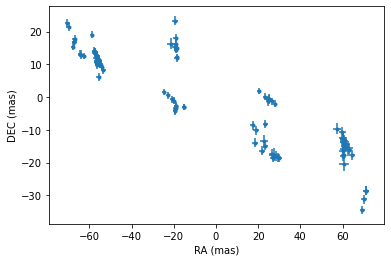

In [7]:
print(epochs_mjd.shape, alpha_abs_st.shape, delta_abs.shape)

plt.errorbar(alpha_abs_st,delta_abs,xerr=eps,yerr=eps,fmt='.')
plt.xlabel('RA (mas)')
plt.ylabel('DEC (mas)')
plt.show()

In [8]:
def hip_model(params,alpha_abs_st,delta_abs,epochs,epochs_mjd,eps,X,Y,Z,alpha0,delta0,alphadec0_epoch,cos_phi,sin_phi):

    # variables for each of the astrometric fitting parameters
    plx = params['plx']
    pm_ra = params['pm_ra']
    pm_dec = params['pm_dec']
    alpha_H0 = params['alphaH0']
    delta_H0 = params['deltaH0']
    
    #########################################
    ## Compute raoff_model, deoff_model
    a_photo = params['a_photo']
    w = params['w']
    bigw = params['bigw']
    inc = params['inc']
    e = params['e']
    P = params['P']
    T = params['T']
    
    ke = pyasl.KeplerEllipse(a_photo,P,e=e,Omega=bigw-180,i=inc,w=w,tau=T)
    pos = ke.xyzPos(epochs_mjd)
    raoff_model = pos[::,1]
    deoff_model = pos[::,0]
    
    #########################################

    n_epochs = len(epochs)
    dist = np.empty(n_epochs)

    # add parallactic ellipse & proper motion to position (Nielsen+ 2020 Eq 8)
    for i in np.arange(n_epochs):

        # this is the expected offset from the photocenter in alphadec0_epoch (typically 1991.25 for Hipparcos)
        alpha_C_st = alpha_H0 + plx * (
            X[i] * np.sin(np.radians(alpha0)) - 
            Y[i] * np.cos(np.radians(alpha0))
        ) + (epochs[i] - alphadec0_epoch) * pm_ra
        delta_C = delta_H0 + plx * (
            X[i] * np.cos(np.radians(alpha0)) * np.sin(np.radians(delta0)) + 
            Y[i] * np.sin(np.radians(alpha0)) * np.sin(np.radians(delta0)) -
            Z[i] * np.cos(np.radians(delta0))
        ) + (epochs[i] - alphadec0_epoch) * pm_dec

        # add in pre-computed secondary perturbations
        alpha_C_st += raoff_model[i]
        delta_C += deoff_model[i]

        # calculate distance between line and expected measurement (Nielsen+ 2020 Eq 6) [mas]
        dist[i] = np.abs(
            (alpha_abs_st[i] - alpha_C_st) * cos_phi[i] + 
            (delta_abs[i] - delta_C) * sin_phi[i]
        )

    return dist / eps

In [9]:
def hip_model_plot(params,epochs,epochs_mjd,eps,X,Y,Z,alpha0,delta0,alphadec0_epoch,cos_phi,sin_phi):

    # variables for each of the astrometric fitting parameters
    plx = params['plx']
    pm_ra = params['pm_ra']
    pm_dec = params['pm_dec']
    alpha_H0 = params['alphaH0']
    delta_H0 = params['deltaH0']
    
    #########################################
    ## Compute raoff_model, deoff_model
    a_photo = params['a_photo']
    w = params['w']
    bigw = params['bigw']
    inc = params['inc']
    e = params['e']
    P = params['P']
    T = params['T']
    
    ke = pyasl.KeplerEllipse(a_photo,P,e=e,Omega=bigw-180,i=inc,w=w,tau=T)
    pos = ke.xyzPos(epochs_mjd)
    raoff_model = pos[::,1]
    deoff_model = pos[::,0]
    
    #########################################

    n_epochs = len(epochs)
    modelx = np.empty(n_epochs)
    modely = np.empty(n_epochs)

    # add parallactic ellipse & proper motion to position (Nielsen+ 2020 Eq 8)
    for i in np.arange(n_epochs):

        # this is the expected offset from the photocenter in alphadec0_epoch (typically 1991.25 for Hipparcos)
        alpha_C_st = alpha_H0 + plx * (
            X[i] * np.sin(np.radians(alpha0)) - 
            Y[i] * np.cos(np.radians(alpha0))
        ) + (epochs[i] - alphadec0_epoch) * pm_ra
        delta_C = delta_H0 + plx * (
            X[i] * np.cos(np.radians(alpha0)) * np.sin(np.radians(delta0)) + 
            Y[i] * np.sin(np.radians(alpha0)) * np.sin(np.radians(delta0)) -
            Z[i] * np.cos(np.radians(delta0))
        ) + (epochs[i] - alphadec0_epoch) * pm_dec

        # add in pre-computed secondary perturbations
        alpha_C_st += raoff_model[i]
        delta_C += deoff_model[i]
        
        modelx[i] = alpha_C_st
        modely[i] = delta_C
        
    return(modelx,modely)

In [10]:
def photocenter_model_plot(params,epochs_mjd):
    
    #########################################
    ## Compute raoff_model, deoff_model
    a_photo = params['a_photo']
    w = params['w']
    bigw = params['bigw']
    inc = params['inc']
    e = params['e']
    P = params['P']
    T = params['T']
    
    ke = pyasl.KeplerEllipse(a_photo,P,e=e,Omega=bigw-180,i=inc,w=w,tau=T)
    pos = ke.xyzPos(epochs_mjd)
    raoff_model = pos[::,1]
    deoff_model = pos[::,0]
    
    return(raoff_model,deoff_model)

In [35]:
def photocenter_data_plot(params,alpha_abs_st,delta_abs,epochs,epochs_mjd,eps,X,Y,Z,alpha0,delta0,alphadec0_epoch,cos_phi,sin_phi):

    # variables for each of the astrometric fitting parameters
    plx = params['plx']
    pm_ra = params['pm_ra']
    pm_dec = params['pm_dec']
    alpha_H0 = params['alphaH0']
    delta_H0 = params['deltaH0']

    n_epochs = len(epochs)
    dist_x = np.empty(n_epochs)
    dist_y = np.empty(n_epochs)

    # add parallactic ellipse & proper motion to position (Nielsen+ 2020 Eq 8)
    for i in np.arange(n_epochs):

        # this is the expected offset from the photocenter in alphadec0_epoch (typically 1991.25 for Hipparcos)
        alpha_C_st = alpha_H0 + plx * (
            X[i] * np.sin(np.radians(alpha0)) - 
            Y[i] * np.cos(np.radians(alpha0))
        ) + (epochs[i] - alphadec0_epoch) * pm_ra
        delta_C = delta_H0 + plx * (
            X[i] * np.cos(np.radians(alpha0)) * np.sin(np.radians(delta0)) + 
            Y[i] * np.sin(np.radians(alpha0)) * np.sin(np.radians(delta0)) -
            Z[i] * np.cos(np.radians(delta0))
        ) + (epochs[i] - alphadec0_epoch) * pm_dec


        # calculate distance between line and expected measurement (Nielsen+ 2020 Eq 6) [mas]
        dist_x[i] = (alpha_abs_st[i] - alpha_C_st) 
        dist_y[i] = (delta_abs[i] - delta_C)

    return dist_x,dist_y

In [21]:
params = Parameters()

## binary parameters
params.add('w',   value= 305.0307734, vary=False)
params.add('bigw', value= 135.0579546, vary=False)
params.add('inc', value= 77.60023562, vary=False)
params.add('e', value= 0.519665094, vary=False)
params.add('a_photo', value= 10, min=0)
params.add('P', value= 14.53941024*365.25, vary=False)
params.add('T', value= 54287.99346, vary=False)

## hipparcos parameters
params.add('plx', value = plx0, min=0)
params.add('pm_ra', value = pm_ra0)
params.add('pm_dec', value = pm_dec0)
params.add('alphaH0', value = 0)
params.add('deltaH0', value = 0)

In [22]:
minner = Minimizer(hip_model, params, fcn_args=(alpha_abs_st,delta_abs,epochs,epochs_mjd,eps,X,Y,Z,alpha0,delta0,alphadec0_epoch,cos_phi,sin_phi))
result = minner.minimize()

report_fit(result)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 15
    # data points      = 99
    # variables        = 6
    chi-square         = 552.038888
    reduced chi-square = 5.93590202
    Akaike info crit   = 182.131366
    Bayesian info crit = 197.702085
[[Variables]]
    w:        305.0308 (fixed)
    bigw:     135.058 (fixed)
    inc:      77.60024 (fixed)
    e:        0.5196651 (fixed)
    a_photo:  11.0347579 +/- 5.07324135 (45.98%) (init = 10)
    P:        5310.52 (fixed)
    T:        54287.99 (fixed)
    plx:      12.1255023 +/- 0.67766452 (5.59%) (init = 11.86)
    pm_ra:    47.5847583 +/- 1.58926835 (3.34%) (init = 44.49)
    pm_dec:  -17.8379113 +/- 1.44700305 (8.11%) (init = -14.82)
    alphaH0: -5.08304534 +/- 2.41416338 (47.49%) (init = 0)
    deltaH0:  5.40028959 +/- 2.51779538 (46.62%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(a_photo, deltaH0) = 0.986
    C(a_photo, alphaH0) = -0.969
    C(a_photo, pm_dec)  = -0.95

In [23]:
## make some plots
best_params = result.params

epochs_model = np.linspace(min(epochs),max(epochs),1000)
#epoch_og_model = Time(epochs_model, format='decimalyear', scale='utc')
epochs_mjd_model = np.linspace(min(epochs_mjd),max(epochs_mjd),1000)

# compute Earth XYZ position in barycentric coordinates for model
bary_pos_model, _ = get_body_barycentric_posvel('earth', Time(epochs_model, format='decimalyear', scale='utc'))
X_model = bary_pos_model.x.value # [au]
Y_model = bary_pos_model.y.value # [au]
Z_model = bary_pos_model.z.value # [au]

modelx,modely = hip_model_plot(best_params,epochs_model,epochs_mjd_model,eps,X_model,Y_model,Z_model,alpha0,delta0,alphadec0_epoch,cos_phi,sin_phi)
datax,datay,errx,erry = alpha_abs_st,delta_abs,eps,eps

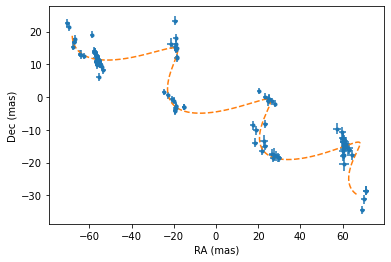

In [24]:
plt.errorbar(datax,datay,yerr=erry,xerr=errx,fmt='.')
plt.plot(modelx,modely,'--')

plt.xlabel('RA (mas)')
plt.ylabel('Dec (mas)')
plt.show()

In [39]:
#########################################
## subtract out Hipparcos motion parameters to see photocenter
#########################################

epochs_mjd_photo_model = np.linspace(min(epochs_mjd),min(epochs_mjd)+best_params['P'].value,1000)

resid_x,resid_y = photocenter_data_plot(best_params,alpha_abs_st,delta_abs,epochs,epochs_mjd,eps,X,Y,Z,alpha0,delta0,alphadec0_epoch,cos_phi,sin_phi)
model_photo_x,model_photo_y = photocenter_model_plot(best_params,epochs_mjd_photo_model)

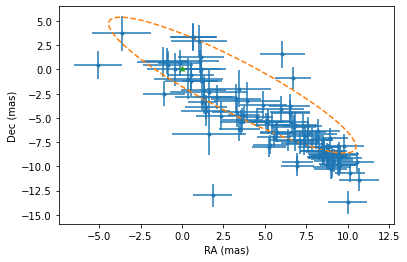

In [42]:
plt.errorbar(resid_x,resid_y,xerr=eps,yerr=eps,fmt='.')
plt.plot(model_photo_x,model_photo_y,'--')
plt.xlabel('RA (mas)')
plt.ylabel('Dec (mas)')
plt.plot(0,0,'*')

In [ ]:
print(max(epochs_photo_model) - min(epochs_photo_model))